In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
from lmfit.models import GaussianModel

In [2]:
from astropy.table import Table,vstack,unique
from astropy.io import fits
import glob

# To Dos
- figure out best way to detrend
    - why is it returning 0s/nans?
- more S testing
    - error to use?

# Define Functions

In [3]:
def sf(file,dpi=200):
    plt.savefig(file+'.png',dpi=dpi,bbox_inches=False)

In [4]:
def detrend(c,window=3,zeros=False):
#     print('Smooth (window = ', window, ') and detrend data...')
    counts = np.array(c)
    #inds where counts are zero -- will want to change to nans (assumption that zero counts means not exposed)
    if zeros: 
        zinds = np.where(counts==0)
        zinds = list(zinds[0])
        counts[zinds] = np.nan
        print(zinds)
    c1smooth = signal.savgol_filter(counts, window, 1)
    c1mean = np.nanmean(counts)
    c1det = counts-c1smooth  + c1mean
    return c1det

In [5]:
def periodogram(time,counts,minp,maxp,sec=True,plot=True):
    '''Perform and plot single LS periodogram.
    Two different return options.'''
    fig = plt.figure(figsize=(8, 4))

    ls = LombScargle(time, counts)
    freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/maxp,
                           maximum_frequency=1/minp,
                           samples_per_peak=10)
#     if bayes: power = np.exp(power)
    if sec and plot: plt.plot((1/freq)/(3600*24),power,color='black')
    elif plot: plt.plot(1/freq,power,color='black')
    best_freq = freq[np.argmax(power)]
    if plot:
        plt.xlabel('Period',fontsize=14)
        plt.ylabel('Power',fontsize=14)
#     if more:
#         return freq, power, 1/best_freq
    if sec: return ('days:',(1/best_freq)/(3600*24))
    else: return 1/best_freq

In [6]:
def binev(evts,bins=0.1,window=3,minp=1,maxp=5):
    '''Bin events; optional to detrend and run periodogram followed by phase-folded output.
    Can pass in list of events to join tables
    For now, pass in evt tables but can change to read fits files
    Assumes day in evt file
    bins in days
    NOT USED IN THIS NOTEBOOK'''
    if len(evts)>1 and len(evts)<8: 
        evt = vstack(evts)
        evt = unique(evt,keys='time')
    else: evt = evts
    hist = plt.hist(evt['day'],bins=np.arange(evt['day'][0],evt['day'][-1],bins),histtype='step',color='black')        
    plt.close()
    evfr = pd.DataFrame(columns=['day','counts','det'])
    evfr['day'] = hist[1][:-1]
    evfr['counts'] = hist[0]
    evfr = evfr[evfr['counts']!=0] #filter out in-between bins
    det = detrend(evfr['counts'],window=window)
    evfr['det'] = det
    fig,ax = plt.subplots(3,1,figsize=(6,16))
    bpd = periodogram(evfr['day'],evfr['counts'],minp=minp,maxp=maxp,sec=False)
    bpddet = periodogram(evfr['day'],evfr['det'],minp=minp,maxp=maxp,sec=False)
    ax[0].scatter(evfr['day'],evfr['counts'],color='darkseagreen',label='original')
    ax[0].scatter(evfr['day'],evfr['det'],color='navy',label='detrended')
    ax[0].legend()
    ax[1].scatter(evfr['day']%bpd,evfr['counts'],color='darkseagreen')
    ax[2].scatter(evfr['day']%bpddet,evfr['det'],color='navy')

    return bpd,bpddet

# Read in Event Files

In [7]:
evts = glob.glob('s*.fits')
evts

['src_13816.fits',
 'src_15496.fits',
 'src_13812.fits',
 'src_15553.fits',
 'src_13813.fits',
 'src_13814.fits',
 'src_13815.fits']

In [8]:
#make list of astropy event tables
#seven elements for seven obsids
tabs = []
for e in evts:
    hdu_list = fits.open(e, memmap=True)
    t = Table(hdu_list[1].data)
    t['day'] = t['time']/(3600*24)
    tabs.append(t)
    print(e,t['time'][0])

src_13816.fits 465025372.8442148
src_15496.fits 464434911.77284586
src_13812.fits 463862614.391263
src_15553.fits 466218621.51459354
src_13813.fits 463601910.9877028
src_13814.fits 464514703.4699503
src_13815.fits 464776486.86331296


In [9]:
def sorf(e):
    return e['day'][0]
#sort list of tables by start time in each
tabs.sort(key=sorf)

In [10]:
#make astropy table of all events (stack obsids)
join = vstack(tabs)

In [11]:
#make sure only unique events kept
join = unique(join,keys='time')

- so we want to fold a lightcurve rather than evts
- lightcurve already has even time binning
- so we essentially want to bin within the counts or det vs. day plot
- we can do this with arrays by reshaping and summing along that axis

# initial goal: phase-fold lightcurve by some period and give S

In [12]:
#define function to make lightcurve hist using table of events
def lc(evt,dbin):
    '''
    evt: table of events, including time in days, or list of tables of events
    dbin: size of bin in days
    TO DO: rather than list, just add obsid and do find allbins without a loop
    non-constant bin width so need to divide by bin width for count rate
    count rate per day so higher than original in each bin
    '''
    #list of event tables (see to-do)
    if isinstance(evt,list):
        allb = []
        for i in range(len(evt)):
            tbins = np.arange(tabs[i]['day'][0],tabs[i]['day'][-1],dbin)
            #add last time in obsid to list of bins
            #addition of small offset so that that last time count is included in bin and not between obsids
            offset = 1e-2*dbin
            tbins = np.concatenate([tbins,[offset+tabs[i]['day'][-1]]])
            allb.append(tbins)
        #make into one array rather than list of seven arrays
        allb = np.concatenate(allb)
        #join tables
        join = vstack(tabs)
        join = unique(join,keys='time')
        h = plt.hist(join['day'],bins=allb,histtype='step',color='black')
        #immediately divide by bin width to avoid confusion down the line
        bin_wid = h[1][1:]-h[1][:-1] #width is end of bin - beginning of bin
        #calculate count rate using counts and bin width
        cr = h[0]/bin_wid
        #CR PER DAY SO INCREASES FROM ORIGINAL
        newh = (cr,h[1])
        #for now, outputs original histogram but returns cr
        return newh
    else:
        h = plt.hist(evt['day'],bins=np.arange(evt['day'][0],evt['day'][-1],dbin),histtype='step',color='black')
    return h

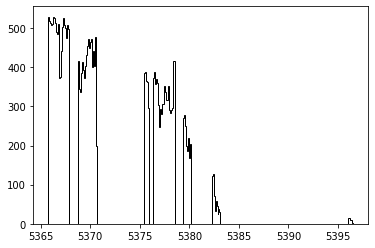

In [13]:
alhist = lc(tabs,0.1)

In [14]:
bin_wid = alhist[1][1:]-alhist[1][:-1]

In [15]:
alhist[0][20:30]

array([4969.99999998, 4958.93505907,    0.        , 4149.99999998,
       3449.99999999, 3369.99999999, 3849.99999999, 4129.99999998,
       3929.99999999, 3719.99999999])

In [16]:
bin_wid[20:30] #showing how bin width changes between obsids

array([0.1       , 0.00201656, 0.91538394, 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ])

- see weirdly high point below
- really small bin and division of counts by bin width gives high num for count rate
- but probably high error so should get rid of it altogether

In [17]:
#higher rates since bin width less than a day
#these are count rates per day
alhist[0][:10]

array([5289.99999998, 5179.99999998, 5139.99999998, 5089.99999998,
       5109.99999998, 5279.99999998, 5249.99999998, 5139.99999998,
       4909.99999998, 4859.99999998])

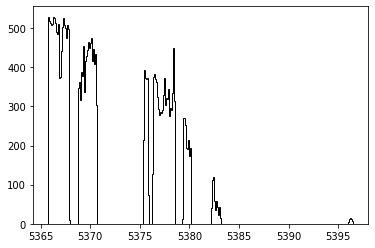

In [18]:
jhist = lc(join,0.1)

Text(0.5, 0, 'day')

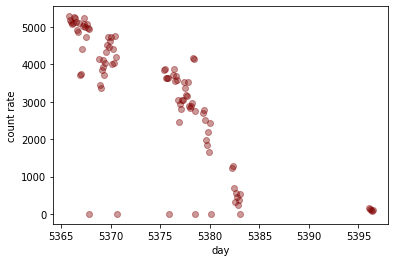

In [19]:
plt.scatter(alhist[1][:-1],alhist[0],color='maroon',alpha=.4,label='new binning method')
plt.ylabel('count rate')
plt.xlabel('day')
# plt.axhline(0)
#can filter out 0s and the high point later

In [20]:
for t in range(7):
    print(tabs[t]['day'][-1])

5367.863875215975
5370.626650595482
5375.884382788588
5378.552788995798
5380.14073770903
5383.0913437821355
5396.4750764006985


In [21]:
#without offset, get nonzero counts between obsids
#leave this here for check
alhist[0][alhist[0]<10]

array([0., 0., 0., 0., 0., 0.])

In [22]:
#bins where counts less than ten
binz = np.array(np.where(alhist[0]<10))
print(alhist[1][binz])
print(alhist[1][binz+1])
#so those low counts within the times between obsids for some reason
#because end of a bin is exclusive

[[5367.86487522 5370.6276506  5375.88538279 5378.553789   5380.14173771
  5383.09234378]]
[[5368.78025916 5375.40407144 5376.32758646 5379.35748684 5382.23811162
  5396.04886012]]


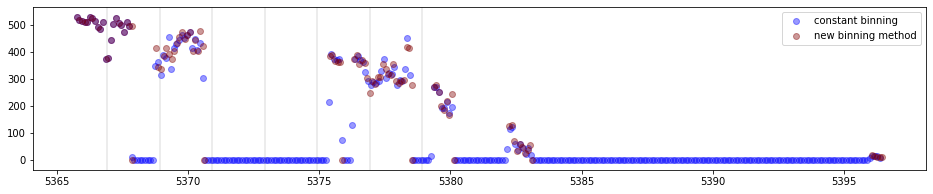

In [23]:
#let's compare
#see markdown above about high point at end of first obsid: should show large error or remove and explain

plt.figure(figsize=(16,3))
plt.scatter(jhist[1][:-1],jhist[0],color='blue',alpha=.4,label='constant binning')
# plt.plot(jhist[1][:-1],jhist[0],color='blue',alpha=.2)

#divide by ten to compare
#successfully got rid of weird points at end of obsids
plt.scatter(alhist[1][:-1],alhist[0]/10,color='maroon',alpha=.4,label='new binning method')
# plt.plot(alhist[1][:-1],alhist[0]/10,color='maroon',alpha=.2)
plt.legend()
plt.axvline(5366.93,color='grey',alpha=.2)
plt.axvline(5368.93,color='grey',alpha=.2)
plt.axvline(5370.93,color='grey',alpha=.2)
plt.axvline(5372.93,color='grey',alpha=.2)
plt.axvline(5374.93,color='grey',alpha=.2)
plt.axvline(5376.93,color='grey',alpha=.2)
plt.axvline(5378.93,color='grey',alpha=.2)
# sf('newoldbinlc')

In [24]:
#one function creating lightcurve and making DataFrame, including detrended column
def lcfr(evt,dbin,window=3,det=False,nan=False):
    h = lc(evt,dbin)
    plt.close()
    fr = pd.DataFrame(columns=['day','counts','det','bin'])
    #can update to get better time estimate (central time rather than bin start time)
    fr['day'] = h[1][:-1]
    fr['counts'] = h[0]
    #bin width (exposure time) in bin column
    fr['bin'] = (h[1][1:]-h[1][:-1])
    #find places with different bin widths and replace bin
    btwn = np.where(fr['bin']>(2*dbin))
    btwn = tuple(btwn[0])
    if nan: fr['bin'][btwn] = np.nan
    else: fr['bin'][btwn] = 0
    if det: 
        detr = detrend(fr['counts'],window=window,zeros=True)
        #for now, leaving zero count rates as nans, but change here if something messed up
#         detr[np.isnan(detr)==True] = 0
        fr['det'] = detr
        #reset nan values to zero in detrended 
        fr['det'][np.isnan(fr['det'])==True] = 0
    return fr

#### detrended LC below 
notice that eclipses (grey lines spaced by two days) are at the lowest points!

of course this is dependent on binning and detrending

[22, 42, 48, 72, 81, 91]


Text(0.5, 0, 'Days')

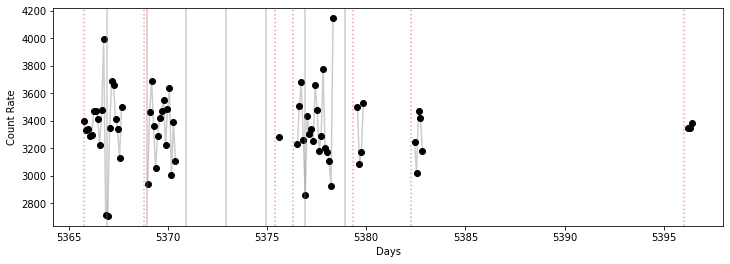

In [25]:
#detrended LC 
frt2 = lcfr(tabs,0.1,det=True,window=5)
#for lightcurve, can make counts of 0 back into nans
frt2['det'][frt2['det']==0] = np.nan
#need to update detrending once again
plt.figure(figsize=(12,4))
plt.scatter(frt2['day'],frt2['det'],color='black')
plt.plot(frt2['day'],frt2['det'],color='black',alpha=.2)

plt.axvline(5366.93,color='grey',alpha=.4,label='eclipse')
plt.axvline(5368.93,color='grey',alpha=.4)
plt.axvline(5370.93,color='grey',alpha=.4)
plt.axvline(5372.93,color='grey',alpha=.4)
plt.axvline(5374.93,color='grey',alpha=.4)
plt.axvline(5376.93,color='grey',alpha=.4)
plt.axvline(5378.93,color='grey',alpha=.4)
for i in range(7):
    plt.axvline(tabs[i]['day'][0],color='red',alpha=.4,linestyle='dotted')
plt.ylabel('Count Rate')
plt.xlabel('Days')
# sf('detLC0.1_win5')

## random points where det is 0??

In [26]:
#without switching to nans
#why are there random points where det is at 0???
frt3 = lcfr(tabs,0.1,det=True,window=3)
frt3[20:30]

[22, 42, 48, 72, 81, 91]


,day,counts,det,bin
20,5367.762859,4970.000000,3326.986859,0.100000
21,5367.862859,4958.935059,0.000000,0.002017
22,5367.864875,0.000000,0.000000,0.000000
23,5368.780259,4150.000000,0.000000,0.100000
24,5368.880259,3450.000000,3156.631879,0.100000
25,5368.980259,3370.000000,3176.631879,0.100000
26,5369.080259,3850.000000,3429.965213,0.100000
27,5369.180259,4130.000000,3523.298546,0.100000
28,5369.280259,3930.000000,3366.631879,0.100000
29,5369.380259,3720.000000,3189.965213,0.100000


[22, 23, 24, 25, 26, 27, 28, 29, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 102, 103, 104, 128, 129, 130, 131, 132, 133, 134, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,

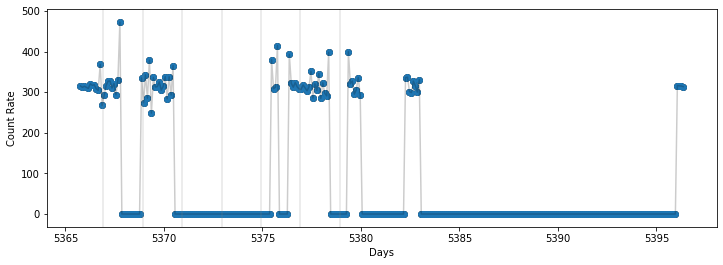

In [27]:
#see that not effective with old binning that is incorrect between obsids
frt = lcfr(join,0.1,det=True,window=3)
plt.figure(figsize=(12,4))
plt.scatter(frt['day'],frt['det'],color='black')
plt.plot(frt['day'],frt['det'],color='black',alpha=.2)

plt.axvline(5366.93,color='grey',alpha=.2)
plt.axvline(5368.93,color='grey',alpha=.2)
plt.axvline(5370.93,color='grey',alpha=.2)
plt.axvline(5372.93,color='grey',alpha=.2)
plt.axvline(5374.93,color='grey',alpha=.2)
plt.axvline(5376.93,color='grey',alpha=.2)
plt.axvline(5378.93,color='grey',alpha=.2)
plt.ylabel('Count Rate')
plt.xlabel('Days')
plt.scatter(frt['day'],frt['det'])

In [28]:
#function to take dataframe of lightcurve, phase-fold, and calculate S
def fold(evt,dbin=0.1,window=5,pd=2,pbins=16,color='black',detf=False,retph=False,linestyle='solid'):
    '''
    evt: table of events, including day
    dbin: bin size for light curve, in days
    window: detrending window
    pd: period for phase-folding
    pbins: number of phase bins
    detf: boolean; if True: use detrended data in phase-fold
    retph: True returns histogram result but no plot
    '''
    #get dataframe with day, counts, det (detrended counts)
    fr = lcfr(evt,dbin,window=window,det=detf)
    fr['phase'] = fr['day']%pd
    #not working with nans in hist so replace with zeros
    if detf: 
        #remove rows nans?
#         fr['det'][np.isnan(fr['det'])==True] = 0
#         fr['bin'][fr['det']==0] = 0

        #not sure why there are detrended nans, but dropping
        nd = np.where(np.isnan(fr['det'])==True)
        nd2 =  np.where(fr['det']==0)
        nd = list(nd[0])
        nd2 = list(nd2[0])
        nod = nd+nd2
#         print(nod)
        fr = fr.drop(index=nod)
    #remove rows where counts is 0
    #indices where zero counts 
    zc = np.where(fr['counts']==0)
    zc = list(zc[0])
#     print(zc)
    fr = fr.drop(index=zc)
    #sort DataFrame by phase
    fr = fr.sort_values(by='phase',ascending=True)
    #phase hist
    #again need to divide by exposure within bin
    if detf: 
#         exp = plt.hist(fr['phase']/2,bins=pbins,weights=fr['bin'],histtype='step',color='red')
#         plt.close()
#         c = plt.hist(fr['phase']/2,bins=pbins,weights=fr['det'],histtype='step',color='red')
#         plt.close()
#         #false number but should be proportionally correct: detrended count rate divided by bin width
#         ph = plt.hist(c[1][:-1],bins=c[1],weights=c[0]/exp[0],histtype='step',color=color,linestyle=linestyle)
        #false number but should be proportionally correct: detrended count rate divided by bin width
        ph = plt.hist(fr['phase']/pd,bins=pbins,weights=fr['det'],histtype='step',color=color,linestyle=linestyle)
        plt.xlim(0,1)
    else: 
        #histogram for exposure (total bin width in phase bin) and histogram for count rate (total count rate) in phase bin
        #then divide binned cr by binned bin width (problem is that values already in count rate; so can fix but will change LC)
#         exp = plt.hist(fr['phase']/2,bins=pbins,weights=fr['bin'],histtype='step',color='red')
#         plt.close()
#         c = plt.hist(fr['phase']/2,bins=pbins,weights=fr['counts'],histtype='step',color='red')
#         plt.close()
#         #false number but should be proportionally correct: detrended count rate divided by bin width
#         ph = plt.hist(c[1][:-1],bins=c[1],weights=c[0]/exp[0],histtype='step',color=color,linestyle=linestyle)
        ph = plt.hist(fr['phase']/pd,bins=pbins,weights=fr['counts'],histtype='step',color=color,linestyle=linestyle)
        plt.xlim(0,1)
    if retph: 
        plt.close()
        return fr,ph
    else:
        plt.xlabel('Phase')
        #if representative number needed, only divide for count rates once
        #right now done twice for the LC, but if just hists used, can wait till this function to do so
        plt.ylabel('Count Rate')
        return fr,ph

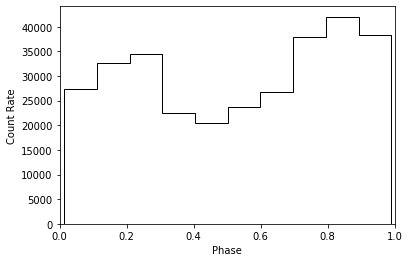

In [29]:
#original 
tes = fold(tabs,dbin=0.1,pd=2,pbins=10)

In [30]:
tes[0][30:40] #bins given zero width when between obsids; also have zero counts

,day,counts,det,bin,phase
41,5370.580259,4199.070785,NaN,0.047391,0.580259
52,5376.627586,3700.000000,NaN,0.100000,0.627586
86,5382.638112,570.000000,NaN,0.100000,0.638112
9,5366.662859,4860.000000,NaN,0.100000,0.662859
53,5376.727586,3590.000000,NaN,0.100000,0.727586
87,5382.738112,450.000000,NaN,0.100000,0.738112
10,5366.762859,5100.000000,NaN,0.100000,0.762859
23,5368.780259,4150.000000,NaN,0.100000,0.780259
54,5376.827586,3040.000000,NaN,0.100000,0.827586
88,5382.838112,250.000000,NaN,0.100000,0.838112


In [31]:
len(tes[0]) #not necessary but dropped six intervals between obsids

91

[11, 22, 26, 39, 44, 50]


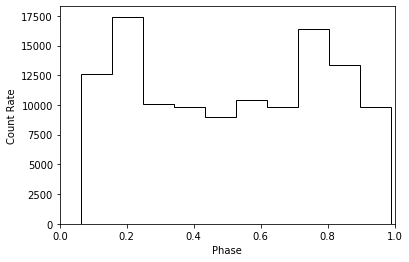

In [32]:
#detrended -- can't trust right now
tesdet = fold(tabs,pd=2,dbin=0.2,window=3,pbins=10,detf=True)

In [33]:
len(tesdet[0])
#drops 30 points b/c they're zero or nans
#need to figure out why they're nans

36

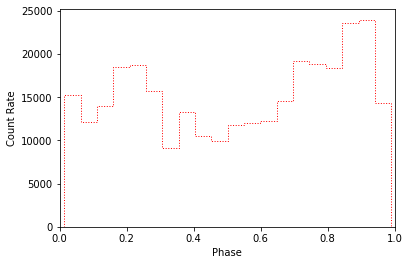

In [34]:
#original
tes = fold(tabs,pd=2,pbins=20,color='red',linestyle='dotted')

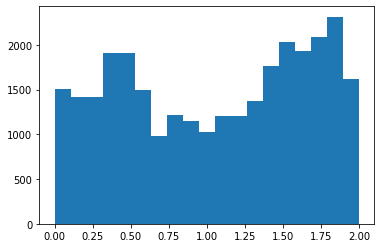

In [35]:
#using original event data, but not best binning and count rates
th = plt.hist(join['day']%2,bins=19)

### look at individual obsids

In [36]:
dbin=0.1 #can test out different binnings here
pbin = 10
tes0,ph0 = fold(tabs[0],pd=2,pbins=pbin,retph=True,dbin=dbin)
tes1,ph1 = fold(tabs[1],pd=2,pbins=pbin,retph=True,dbin=dbin)
tes2,ph2 = fold(tabs[2],pd=2,pbins=pbin,retph=True,dbin=dbin)
tes3,ph3 = fold(tabs[3],pd=2,pbins=pbin,retph=True,dbin=dbin)
tes4,ph4 = fold(tabs[4],pd=2,pbins=pbin,retph=True,dbin=dbin)
tes5,ph5 = fold(tabs[5],pd=2,pbins=pbin,retph=True,dbin=dbin)
tes6,ph6 = fold(tabs[6],pd=2,pbins=pbin,retph=True,dbin=dbin)
phs = [ph0,ph1,ph2,ph3,ph4,ph5,ph6]

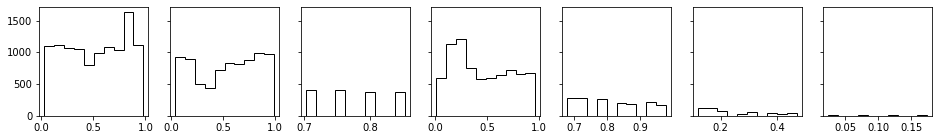

In [37]:
#show histograms with original counts
#only three show eclipses
fig,ax = plt.subplots(1,7,figsize=(16,2),sharey=True)
for p in range(7):
    ax[p].hist(phs[p][1][:-1],bins=phs[p][1],weights=phs[p][0],histtype='step',color='black')    

# Start Calculating Epoch-Folding Statistic
- for now, not that effective in differentiating between periods
- not sure of what to use for error, which will certianly affect it

In [38]:
#compute S for range of periods
def ztest(evt,pds,dbin=0.1,window=3,pbins=10,color='black',detf=False,retph=True,
         plot=False,subs=(1,8),figsize=(16,3)):
    '''Uses fold function for range of periods and computes S for each
    for now can only plot one axis of subplots -- just do when low num of tests'''
    slist = []
    i = 0
#     if plot:
#         fig,ax=plt.subplots(subs[0],subs[1],figsize=figsize,sharey=True)
#plotting not working, maybe b/c of close() in other functions called
    phlist = []
    for p in pds:
        #to do: more efficient to not re-fold evt every time
        fr,ph = fold(evt,pd=p,dbin=dbin,pbins=pbins,window=window,retph=retph,detf=detf)
#         if plot and i<len(ax): ax[i].hist(ph[1][:-1],bins=ph[1],weights=ph[0],histtype='step',color='black')                      
#         s = np.sum((ph[1]-np.mean(ph[0]))**2/np.std(ph[0])**2)
        #clarify what error to use; for now: what stingray uses when no error passed in; maybe should be sqrt of counts
        #but seems like error should be the same for each (not sigma with i subscript)
        mean = np.mean(ph[0])
        err = np.sqrt(mean)
        s = np.sum(((ph[0]-mean)**2)/err**2)

        phlist.append(ph)
        slist.append(s)
        if len(pds)<5:print('period:',p,'s:',s)
        i+=1
    #with many periods, just plot all hists on one plot
    if plot:
        fig,ax = plt.subplots(1,len(phlist),figsize=(2*len(phlist),3),sharey=True)
        i = 0
        for ph in phlist:
            ax[i].hist(ph[1][:-1],bins=ph[1],weights=ph[0],histtype='step',color='black')
            ax[i].text(0.25,4000,str(int(slist[i])))
#             ax[i].text(0.25,4000,str(pds[i]))
            i+=1
    p = np.array(pds)
    slist = np.array(slist)
    print(pds[np.where(slist==np.max(slist))[0][0]])
    return slist

1.95


array([10703.43118486, 23728.57246756, 16569.15922863, 13201.51608172,
       12703.23408439])

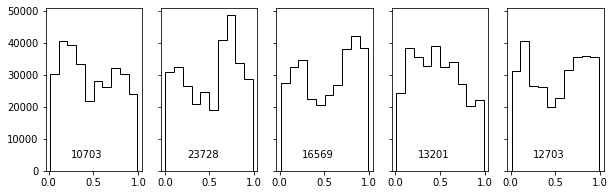

In [39]:
ztest(tabs,np.arange(1.9,2.1,0.05),plot=True)

[22, 42, 48, 72, 81, 91]
[22, 42, 48, 72, 81, 91]
[22, 42, 48, 72, 81, 91]
[22, 42, 48, 72, 81, 91]
[22, 42, 48, 72, 81, 91]
2.1


array([17964.81182006,  9764.23316083, 10337.2149952 , 16192.24523387,
       21134.19371067])

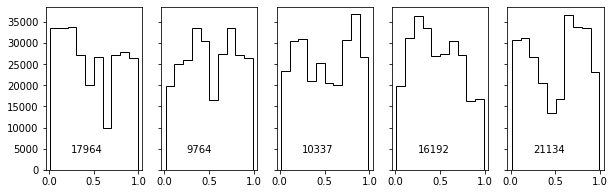

In [40]:
ztest(tabs,np.arange(1.9,2.1,0.05),plot=True,detf=True)

# some tests with individual eclipses

In [41]:
pds = np.arange(1.8,2.1,0.01)
#individually for three obsids with clear eclipses
#this isn't a great idea since only one in each one and other variability going on
#way too sensitive, but they do sometimes agree on correct period

slist0 = ztest(tabs[0],pds,dbin=0.05,pbins=10,plot=False)
slist1 = ztest(tabs[1],pds,dbin=0.05,pbins=10,plot=False)
slist3 = ztest(tabs[3],pds,dbin=0.05,pbins=10,plot=False)

slist01 = ztest(tabs[0],pds,dbin=0.1,pbins=10,plot=False)
slist11 = ztest(tabs[1],pds,dbin=0.1,pbins=10,plot=False)
slist31 = ztest(tabs[3],pds,dbin=0.1,pbins=10,plot=False)

1.8
2.1000000000000005
1.83
1.8
1.9400000000000002
1.84


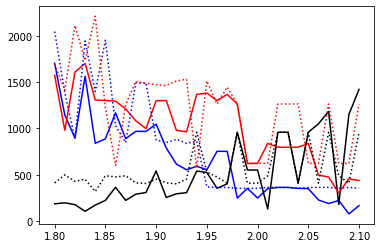

In [42]:
#answer and spikiness *very* sensitive to original binning (both for LC and phase-fold)
plt.plot(pds,slist0,color='blue')
plt.plot(pds,slist1,color='black')
plt.plot(pds,slist3,color='red')

plt.plot(pds,slist01,color='blue',linestyle='dotted')
plt.plot(pds,slist11,color='black',linestyle='dotted')
plt.plot(pds,slist31,color='red',linestyle='dotted')

# tests with whole LC again
- once it's generally working can write function to loop through different periods, phase bins, and LC bins

In [43]:
#repeat using all data
pds = np.arange(1.7,2.1,0.05)
#all data
#first num references LC binning, second: phase binning
alls52 = ztest(tabs,pds,dbin=0.05,pbins=20,plot=False)
alls51 = ztest(tabs,pds,dbin=0.05,pbins=10,plot=False)
alls55 = ztest(tabs,pds,dbin=0.05,pbins=15,plot=False)

alls12 = ztest(tabs,pds,dbin=0.1,pbins=20,plot=False)
alls11 = ztest(tabs,pds,dbin=0.1,pbins=10,plot=False)
alls15 = ztest(tabs,pds,dbin=0.1,pbins=15,plot=False)

# alls11 = ztest(tabs[1],pds,dbin=0.1,pbins=20,plot=False)
# alls31 = ztest(tabs[3],pds,dbin=0.1,pbins=20,plot=False)

1.9500000000000002
1.9500000000000002
2.0
1.9500000000000002
1.9500000000000002
1.9500000000000002


In [44]:
def ztests(evt,pds,dbin=0.1,window=3,pbins=10,color='black',detf=False,retph=True):
    sarr = np.zeros((len(pds),len(dbin),len(pbins)))
    
    j = 0
    for p in pbins:
        i = 0
        for d in dbin:
            slist = ztest(evt,pds,dbin=d,window=window,pbins=p,color='black',detf=False,retph=True,
             plot=False)
            sarr[:,i,j] = slist
            i+=1
        j+=1
    return sarr

In [45]:
sarr = ztests(tabs,[1.9,2,2.1],dbin=[0.1],pbins=[8,10,12,14])

period: 1.9 s: 13481.427541237765
period: 2 s: 16928.964462163953
period: 2.1 s: 11554.349651318635
2
period: 1.9 s: 10703.431184861538
period: 2 s: 16569.159228630448
period: 2.1 s: 12703.23408439395
2
period: 1.9 s: 12012.701255640584
period: 2 s: 20655.099810935637
period: 2.1 s: 17400.47406123073
2
period: 1.9 s: 19848.64253876984
period: 2 s: 26150.46786228994
period: 2.1 s: 17013.892828618715
2


In [46]:
sarr.shape

(3, 1, 4)

In [47]:
np.max(sarr)

26150.46786228994

Text(0.5, 0, 'Phase Bins')

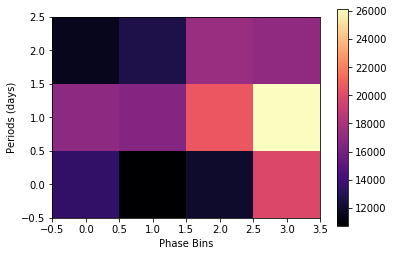

In [48]:
#can fix labels, but gives highest value at period of 2 and 14 phase bins
plt.imshow(sarr[:,0,:],origin='lower',cmap='magma')
plt.colorbar()
plt.ylabel('Periods (days)')
plt.xlabel('Phase Bins')

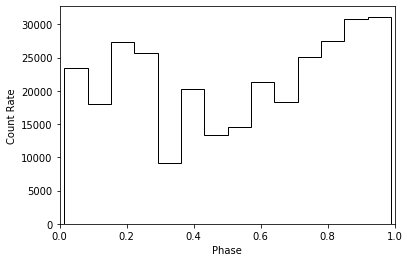

In [49]:
res = fold(tabs,pd=[2],dbin=0.1,pbins=14,window=5,detf=False)

[22, 42, 48, 72, 81, 91]


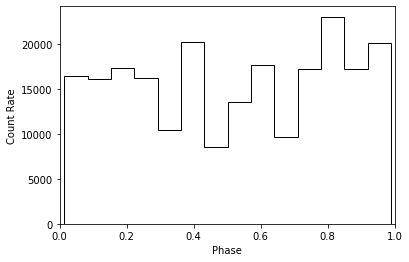

In [50]:
res = fold(tabs,pd=2,dbin=0.1,pbins=14,window=5,detf=True)

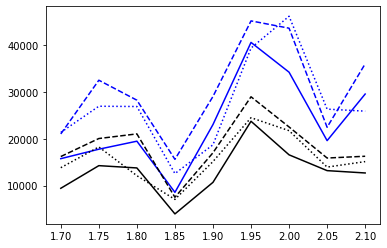

In [51]:
plt.plot(pds,alls51,color='blue')
plt.plot(pds,alls52,color='blue',linestyle='dashed')
plt.plot(pds,alls55,color='blue',linestyle='dotted')

plt.plot(pds,alls11,color='black')
plt.plot(pds,alls12,color='black',linestyle='dashed')
plt.plot(pds,alls15,color='black',linestyle='dotted')

# Place to Check S Values on Made-Up Distributions
- pulse shape, perfectly uniform, and slightly off from uniform
- want s values to reflect these differences

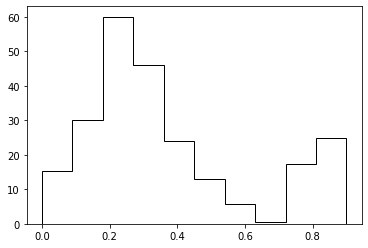

In [52]:
#test S value for more obvious case
st = plt.hist(np.arange(0,1,.1),bins=10,weights=[15.3,30,60,46,24,13,5.6,0.4,17.2,25],histtype='step',color='black')

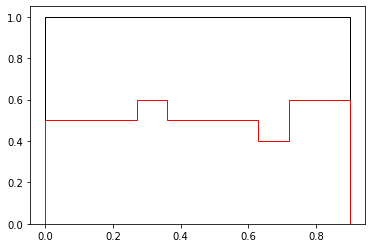

In [53]:
stu = plt.hist(np.arange(0,1,.1),bins=10,weights=np.ones(10),histtype='step',color='black')
st2 = plt.hist(np.arange(0,1,.1),bins=10,weights=[0.5,0.5,0.5,0.6,0.5,0.5,0.5,0.4,0.6,0.6],histtype='step',color='red')

In [54]:
np.nansum(((st[0]-np.nanmean(st[0]))**2)/(np.sqrt(np.nanmean(st[0]))**2))

124.91437632135307

In [55]:
np.nansum(((stu[0]-np.nanmean(stu[0]))**2)/(np.sqrt(np.nanmean(stu[0]))**2))

0.0

In [56]:
np.nansum(((st2[0]-np.nanmean(st2[0]))**2)/(np.sqrt(np.nanmean(st2[0]))**2))

0.0692307692307692

In [57]:
np.nansum(((st[1]-np.nanmean(st[0]))**2)/(np.sqrt(np.nanmean(st[0]))**2))

250.38186046511632

In [58]:
np.nansum(((stu[1]-np.nanmean(stu[0]))**2)/(np.sqrt(np.nanmean(stu[0]))**2))

4.218500000000001

In [59]:
np.nansum(((st2[1]-np.nanmean(st2[0]))**2)/(np.sqrt(np.nanmean(st2[0]))**2))

1.8171153846153847